In [1]:
# Import Required Modules
import librosa
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL import Image

import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import keras
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D, Input
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Activation
from keras.layers import Bidirectional
from keras.layers import LSTM

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# function to extract features from audio file
def getFeaturesTest(filename):

    # Reading File
    y,sr=librosa.load(filename)

    # Mel Frequency Cepstral Coefficients
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)

    # Short Term Fourier Transform
    stft = np.abs(librosa.stft(y))

    # Chromagram from STFT
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)

    # Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y, sr=sr).T,axis=0)

    # Spectral Contrasts
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T,axis=0)

    # Tonal Centroid Features
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y),sr=sr).T,axis=0)

    # Flatten the array
    features = np.concatenate((mfcc, chroma, mel, contrast, tonnetz), axis=0)
    return np.array([features])

In [3]:
# Import Dataset
data = pd.read_csv('AudioFeaturesDataset6classes.csv')

# Input Features
x = np.array(data.drop(['Class'], axis=1))

# Label (Output Feature)
y = []
for i in range(data.shape[0]):
	if data.iloc[i, -1] == 'Axecutting_Sounds':
		y.append([1, 0, 0, 0, 0, 0])
	elif data.iloc[i, -1] == 'Chainsaw_Sounds':
		y.append([0, 1, 0, 0, 0, 0])
	elif data.iloc[i, -1] == 'Forest_Sounds':
		y.append([0, 0, 1, 0, 0, 0])
	elif data.iloc[i, -1] == 'Handsaw_Sounds':
		y.append([0, 0, 0, 1, 0, 0])
	elif data.iloc[i, -1] == 'Rain&Thunder_Sounds':
		y.append([0, 0, 0, 0, 1, 0])
	elif data.iloc[i, -1] == 'Wind_Sounds':
		y.append([0, 0, 0, 0, 0, 1])

# Randomize Data
x,y = shuffle(x, np.array(y))

In [4]:
# Splitting data for Training, Testing and Validation
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.15, random_state=101)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.15, random_state=101)

#### Convolutional Neural Network (CNN-1D) Model File Generation (6 Classes) [Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind]

In [5]:
# Defining Convolutional Neural Network Model (CNN Architecture)
CNN = Sequential()

# Convolutional Layer 1 with 64 Neurons and 193 Input Neurons
CNN.add(Conv1D(64, 3, activation='relu', input_shape=(193,1)))

# Convolutional Layer 2 with 64 Neurons
CNN.add(Conv1D(64, 3, activation='relu'))

# Pooling Layer 1
CNN.add(MaxPooling1D(3))

# Convolutional Layer 3 with 128 Neurons
CNN.add(Conv1D(128, 3, activation='relu'))

# Convolutional Layer 4 with 128 Neurons
CNN.add(Conv1D(128, 3, activation='relu'))

# Average Pooling Layer and Dropout Layer
CNN.add(GlobalAveragePooling1D())
CNN.add(Dropout(0.5))

# Output Layer for 4 classes
CNN.add(Dense(6, activation='softmax'))
CNN.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 191, 64)           256       
                                                                 
 conv1d_1 (Conv1D)           (None, 189, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 64)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 61, 128)           24704     
                                                                 
 conv1d_3 (Conv1D)           (None, 59, 128)           49280     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                 

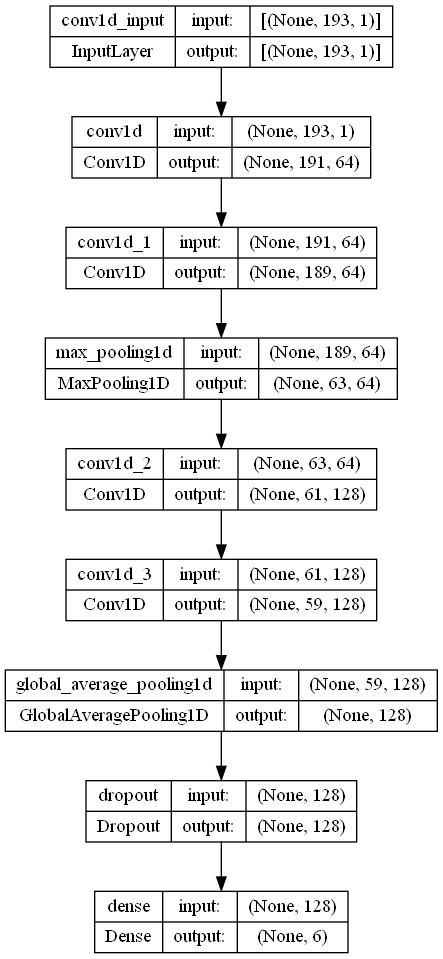

In [6]:
plot_model(CNN, to_file='CNN_model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)
display(Image.open('CNN_model.png'))

In [7]:
tensorboard = TensorBoard(log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto', verbose=1)
checkpoint = ModelCheckpoint(filepath='CNN_Best_Model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)

In [8]:
historyCNN = CNN.fit(xtrain, ytrain, epochs=10, callbacks=[checkpoint, reduce_lr, tensorboard], verbose=1, validation_data=(xval, yval))

Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.9541 - accuracy: 0.6913
Epoch 1: val_accuracy improved from -inf to 0.85948, saving model to CNN_Best_Model.hdf5
163/163 [==============================] - 5s 13ms/step - loss: 0.9541 - accuracy: 0.6913 - val_loss: 0.5176 - val_accuracy: 0.8595 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 0.3879 - accuracy: 0.8954
Epoch 2: val_accuracy improved from 0.85948 to 0.93137, saving model to CNN_Best_Model.hdf5
163/163 [==============================] - 1s 7ms/step - loss: 0.3879 - accuracy: 0.8954 - val_loss: 0.2204 - val_accuracy: 0.9314 - lr: 0.0010
Epoch 3/10
157/163 [===========================>..] - ETA: 0s - loss: 0.2503 - accuracy: 0.9285
Epoch 3: val_accuracy improved from 0.93137 to 0.93355, saving model to CNN_Best_Model.hdf5
163/163 [==============================] - 1s 7ms/step - loss: 0.2474 - accuracy: 0.9293 - val_loss: 0.1714 - val_accuracy: 0.9336 - lr: 0.0010
Epoch 

#### Convolutional Recurrent Neural Network (CRNN-1D) (6 Classes) [Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind]

In [9]:
# Defining Convolutional Recurrent Neural Network Model (CRNN Architecture)
CRNN = Sequential()

# Convolutional Layer 1 with 64 Neurons and 193 Input Neurons
CRNN.add(Conv1D(64, 3, activation='relu', input_shape=(193,1)))

# Convolutional Layer 2 with 64 Neurons 
CRNN.add(Conv1D(64, 3, activation='relu'))

# Pooling Layer 1
CRNN.add(MaxPooling1D(3))

# Recurrent Layer 1 (LSTM) with 64 Neurons
CRNN.add(LSTM(64,return_sequences=False))

# Output Layer for 4 classes
CRNN.add(Dense(6, activation='softmax'))
CRNN.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
CRNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 191, 64)           256       
                                                                 
 conv1d_5 (Conv1D)           (None, 189, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 63, 64)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 46,022
Trainable params: 46,022
Non-trainable params: 0
__________________________________________________

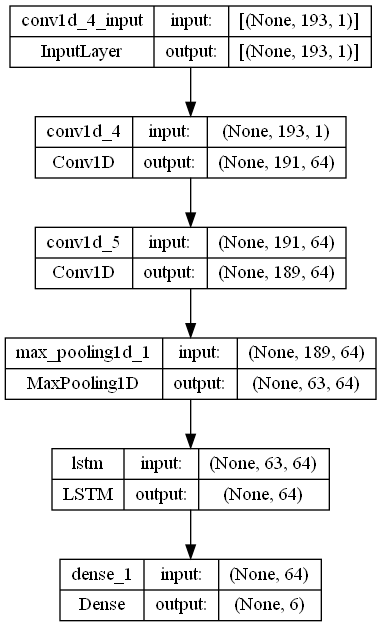

In [10]:
plot_model(CRNN, to_file='CRNN_model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)
display(Image.open('CRNN_model.png'))

In [11]:
tensorboard = TensorBoard(log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto', verbose=1)
checkpoint = ModelCheckpoint(filepath='CRNN_Best_Model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)

In [12]:
historyCRNN = CRNN.fit(xtrain, ytrain, epochs=10, callbacks=[checkpoint, reduce_lr, tensorboard], verbose=1, validation_data=(xval, yval))

Epoch 1/10
162/163 [============================>.] - ETA: 0s - loss: 1.2286 - accuracy: 0.4653
Epoch 1: val_accuracy improved from -inf to 0.46732, saving model to CRNN_Best_Model.hdf5
163/163 [==============================] - 4s 13ms/step - loss: 1.2267 - accuracy: 0.4662 - val_loss: 1.0162 - val_accuracy: 0.4673 - lr: 0.0010
Epoch 2/10
161/163 [============================>.] - ETA: 0s - loss: 0.7030 - accuracy: 0.7213
Epoch 2: val_accuracy improved from 0.46732 to 0.69281, saving model to CRNN_Best_Model.hdf5
163/163 [==============================] - 2s 11ms/step - loss: 0.7009 - accuracy: 0.7224 - val_loss: 0.7738 - val_accuracy: 0.6928 - lr: 0.0010
Epoch 3/10
159/163 [============================>.] - ETA: 0s - loss: 0.4937 - accuracy: 0.8117
Epoch 3: val_accuracy improved from 0.69281 to 0.76362, saving model to CRNN_Best_Model.hdf5
163/163 [==============================] - 2s 11ms/step - loss: 0.4928 - accuracy: 0.8128 - val_loss: 0.5634 - val_accuracy: 0.7636 - lr: 0.0010
E

#### Bidirectional Convolutional Recurrant Neural Network (Bi-CRNN-1D) (6 Classes) [Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind]

In [13]:
# Defining Bidirectional Convolutional Recurrent Neural Network Model (Bi-CRNN Architecture)
BICRNN = Sequential()

# Convolutional Layer 1 with 64 Neurons and 193 Input Neurons
BICRNN.add(Conv1D(64, 3, activation='relu', input_shape=(193,1)))

# Convolutional Layer 2 with 64 Neurons 
BICRNN.add(Conv1D(64, 3, activation='relu'))

# Pooling Layer 1
BICRNN.add(MaxPooling1D(3))

# Bi-Directional Recurrent Layer 1 (Bi-LSTM) with 64 Neurons
BICRNN.add(Bidirectional(layer=LSTM(64,return_sequences=False),merge_mode='concat'))

# Output Layer for 4 classes
BICRNN.add(Dense(6, activation='softmax'))
BICRNN.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
BICRNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 191, 64)           256       
                                                                 
 conv1d_7 (Conv1D)           (None, 189, 64)           12352     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 63, 64)           0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 79,430
Trainable params: 79,430
Non-trai

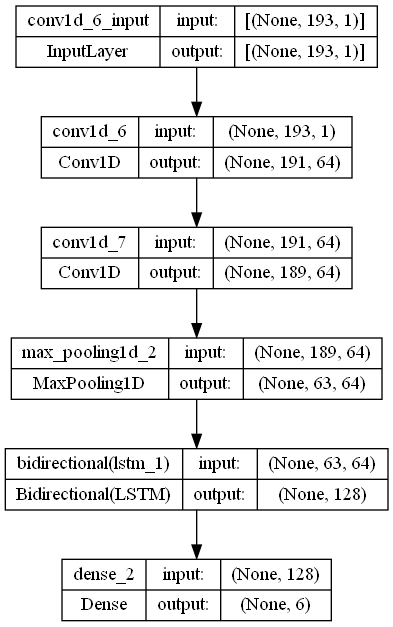

In [14]:
plot_model(BICRNN, to_file='BICRNN_model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)
display(Image.open('BICRNN_model.png'))

In [15]:
tensorboard = TensorBoard(log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto', verbose=1)
checkpoint = ModelCheckpoint(filepath='BICRNN_Best_Model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)

In [16]:
historyBICRNN = BICRNN.fit(xtrain, ytrain, epochs=10, callbacks=[checkpoint, reduce_lr, tensorboard], verbose=1, validation_data=(xval, yval))

Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.4256 - accuracy: 0.8897
Epoch 1: val_accuracy improved from -inf to 0.93900, saving model to BICRNN_Best_Model.hdf5
163/163 [==============================] - 6s 21ms/step - loss: 0.4256 - accuracy: 0.8897 - val_loss: 0.1750 - val_accuracy: 0.9390 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 0.1714 - accuracy: 0.9421
Epoch 2: val_accuracy improved from 0.93900 to 0.94227, saving model to BICRNN_Best_Model.hdf5
163/163 [==============================] - 3s 16ms/step - loss: 0.1714 - accuracy: 0.9421 - val_loss: 0.1640 - val_accuracy: 0.9423 - lr: 0.0010
Epoch 3/10
160/163 [============================>.] - ETA: 0s - loss: 0.1368 - accuracy: 0.9508
Epoch 3: val_accuracy improved from 0.94227 to 0.95534, saving model to BICRNN_Best_Model.hdf5
163/163 [==============================] - 2s 15ms/step - loss: 0.1367 - accuracy: 0.9506 - val_loss: 0.1554 - val_accuracy: 0.9553 - lr: 0.

#### Residual Network (ResNet-34) (6 Classes) [Axecutting, Chainsaw, Forest, Handsaw, Rain & Thunder, Wind]

In [17]:
# Defining Residual Network Model Architecture (ResNet-34)
n_feature_maps = 64

input_shape = (193,1)
input_layer = Input(input_shape)

# BLOCK 1
conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)
conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)
conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)
# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
output_block_1 = keras.layers.add([shortcut_y, conv_z])
output_block_1 = keras.layers.Activation('relu')(output_block_1)

# BLOCK 2
conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)
conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)
conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)
# expand channels for the sum
shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
output_block_2 = keras.layers.add([shortcut_y, conv_z])
output_block_2 = keras.layers.Activation('relu')(output_block_2)

# BLOCK 3
conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)
conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)
conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)
# no need to expand channels because they are equal
shortcut_y = keras.layers.BatchNormalization()(output_block_2)
output_block_3 = keras.layers.add([shortcut_y, conv_z])
output_block_3 = keras.layers.Activation('relu')(output_block_3)

# FINAL BLOCK
gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)
output_layer = keras.layers.Dense(6, activation='softmax')(gap_layer)
resnet = keras.models.Model(inputs=input_layer, outputs=output_layer)

resnet.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 193, 1)]     0           []                               
                                                                                                  
 conv1d_8 (Conv1D)              (None, 193, 64)      576         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 193, 64)     256         ['conv1d_8[0][0]']               
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 193, 64)      0           ['batch_normalization[0][0]']

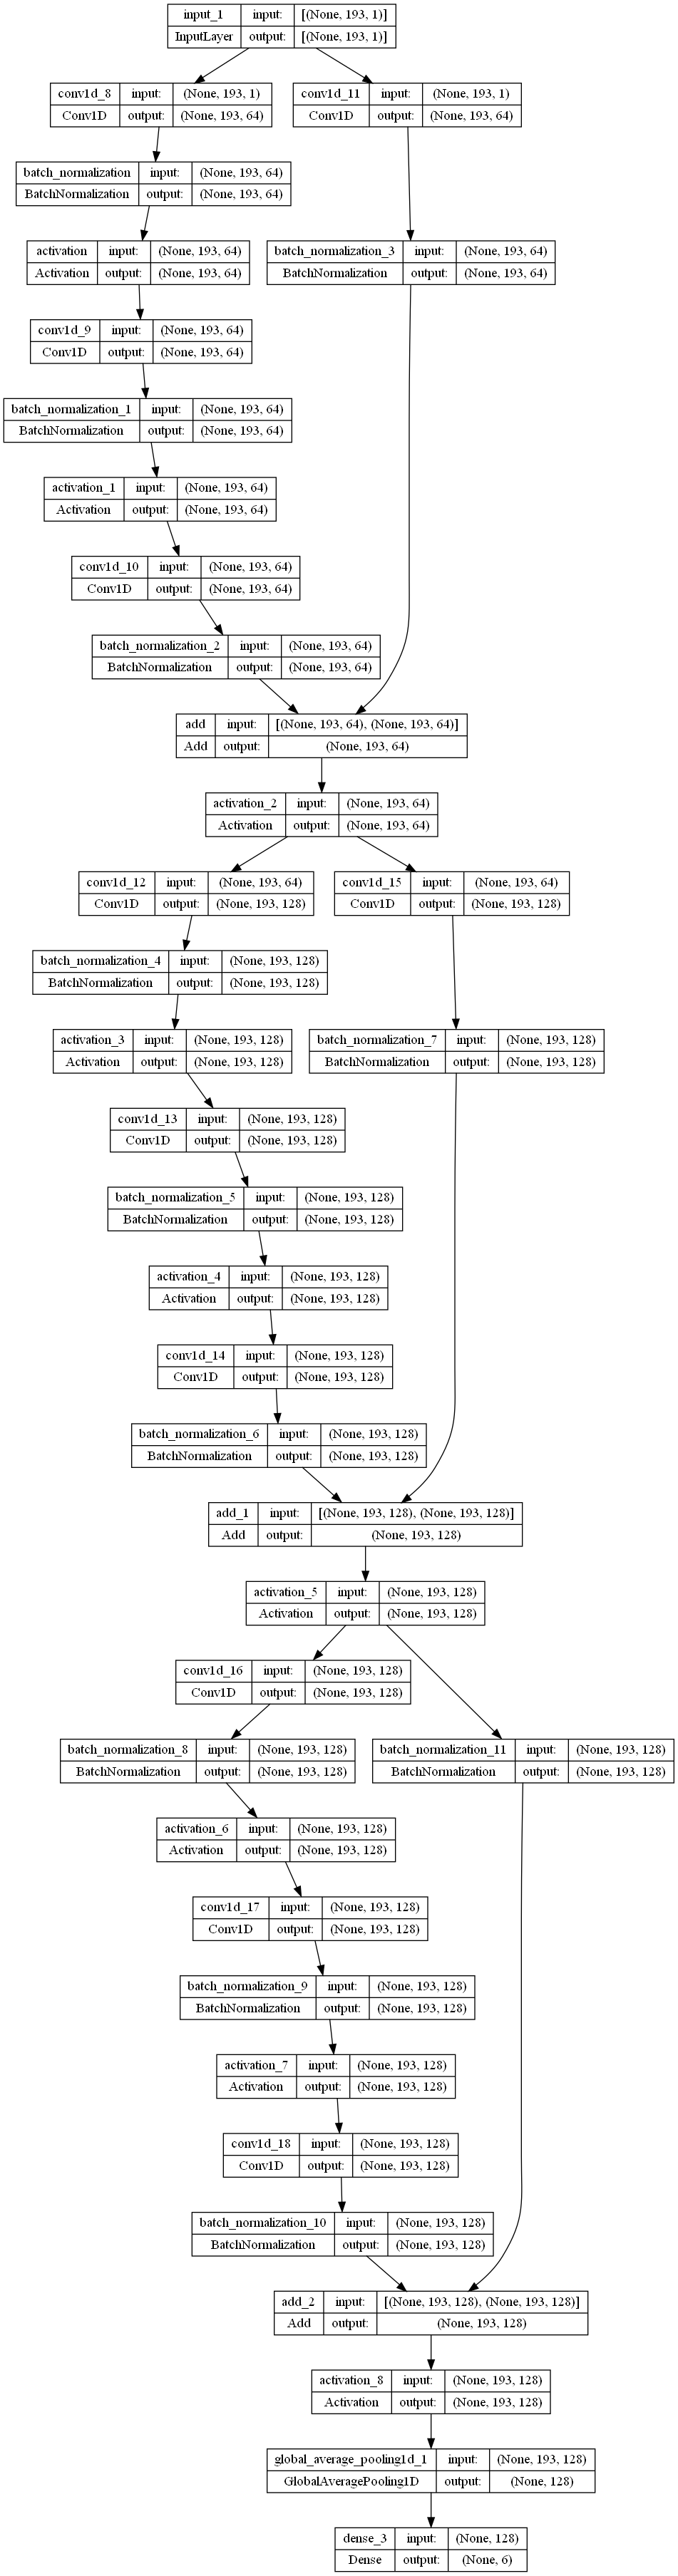

In [18]:
plot_model(resnet, to_file='RESNET_model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)
display(Image.open('RESNET_model.png'))

In [19]:
tensorboard = TensorBoard(log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto', verbose=1)
checkpoint = ModelCheckpoint(filepath='RESNET_Best_Model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)

In [20]:
historyRESNET = resnet.fit(xtrain, ytrain, epochs=10, callbacks=[checkpoint, reduce_lr, tensorboard], verbose=1, validation_data=(xval, yval))

Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.3688 - accuracy: 0.8943
Epoch 1: val_accuracy improved from -inf to 0.93246, saving model to RESNET_Best_Model.hdf5
163/163 [==============================] - 10s 35ms/step - loss: 0.3688 - accuracy: 0.8943 - val_loss: 0.2724 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 0.1672 - accuracy: 0.9448
Epoch 2: val_accuracy did not improve from 0.93246
163/163 [==============================] - 4s 23ms/step - loss: 0.1672 - accuracy: 0.9448 - val_loss: 0.9267 - val_accuracy: 0.7059 - lr: 0.0010
Epoch 3/10
161/163 [============================>.] - ETA: 0s - loss: 0.1437 - accuracy: 0.9505
Epoch 3: val_accuracy improved from 0.93246 to 0.94118, saving model to RESNET_Best_Model.hdf5
163/163 [==============================] - 4s 24ms/step - loss: 0.1439 - accuracy: 0.9504 - val_loss: 0.1703 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 4/10
161/163 [==================

#### Training Accuracy and Loss of Above 4 models

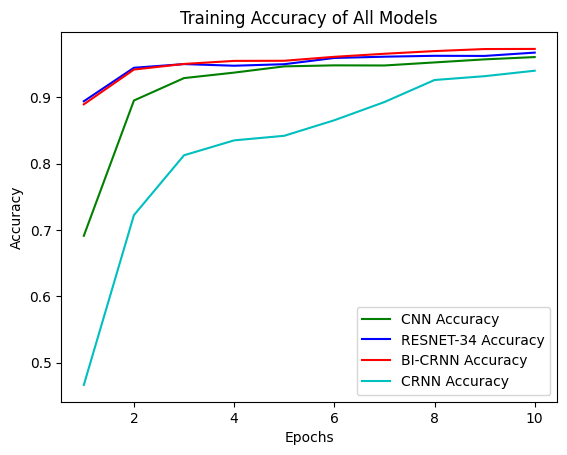

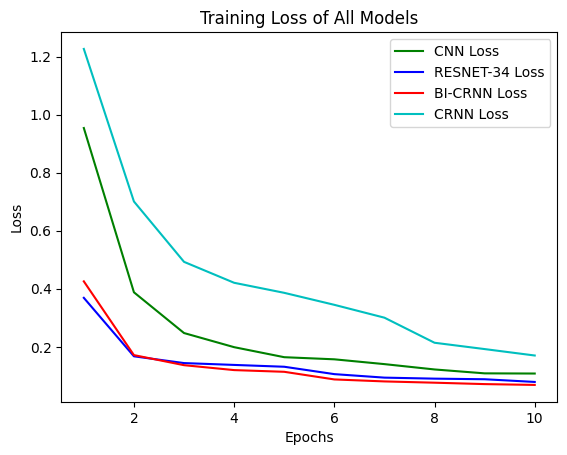

In [21]:
trainCNN = historyCNN.history['accuracy']
trainCRNN = historyCRNN.history['accuracy']
trainBICRNN = historyBICRNN.history['accuracy']
trainRESNET = historyRESNET.history['accuracy']
epochs = range(1,11)
plt.plot(epochs, trainCNN, 'g', label='CNN Accuracy')
plt.plot(epochs, trainRESNET, 'b', label='RESNET-34 Accuracy')
plt.plot(epochs, trainBICRNN, 'r', label='BI-CRNN Accuracy')
plt.plot(epochs, trainCRNN, 'c', label='CRNN Accuracy')
plt.title('Training Accuracy of All Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

trainCNN = historyCNN.history['loss']
trainCRNN = historyCRNN.history['loss']
trainBICRNN = historyBICRNN.history['loss']
trainRESNET = historyRESNET.history['loss']
epochs = range(1,11)
plt.plot(epochs, trainCNN, 'g', label='CNN Loss')
plt.plot(epochs, trainRESNET, 'b', label='RESNET-34 Loss')
plt.plot(epochs, trainBICRNN, 'r', label='BI-CRNN Loss')
plt.plot(epochs, trainCRNN, 'c', label='CRNN Loss')
plt.title('Training Loss of All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Validation Accuracy and Loss of Above 4 models

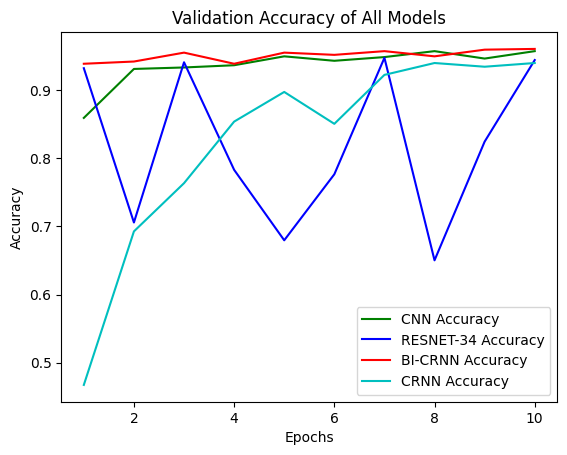

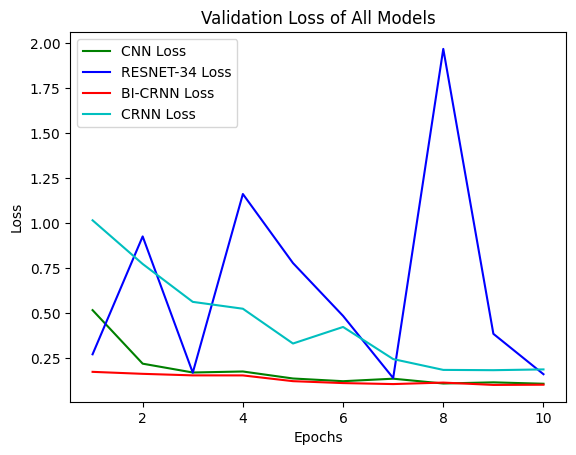

In [22]:
trainCNN = historyCNN.history['val_accuracy']
trainCRNN = historyCRNN.history['val_accuracy']
trainBICRNN = historyBICRNN.history['val_accuracy']
trainRESNET = historyRESNET.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, trainCNN, 'g', label='CNN Accuracy')
plt.plot(epochs, trainRESNET, 'b', label='RESNET-34 Accuracy')
plt.plot(epochs, trainBICRNN, 'r', label='BI-CRNN Accuracy')
plt.plot(epochs, trainCRNN, 'c', label='CRNN Accuracy')
plt.title('Validation Accuracy of All Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

trainCNN = historyCNN.history['val_loss']
trainCRNN = historyCRNN.history['val_loss']
trainBICRNN = historyBICRNN.history['val_loss']
trainRESNET = historyRESNET.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, trainCNN, 'g', label='CNN Loss')
plt.plot(epochs, trainRESNET, 'b', label='RESNET-34 Loss')
plt.plot(epochs, trainBICRNN, 'r', label='BI-CRNN Loss')
plt.plot(epochs, trainCRNN, 'c', label='CRNN Loss')
plt.title('Validation Loss of All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()